In [292]:
from datetime import datetime, timedelta
from matplotlib.pylab import rcParams
from pandas import DataFrame
from pmdarima.arima import auto_arima, ARIMA
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.preprocessing import PolynomialFeatures
from statistics import mean
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import trange, tqdm, tnrange
from xgboost import plot_importance, plot_tree, XGBClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from xgboost.sklearn import XGBClassifier
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import datetime as dt
import getpass
import graphviz
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pmdarima as pm
import pycountry
import pycountry_convert as pc
import pydotplus
import pyodbc 
import seaborn as sns
import sklearn.linear_model as lm
import statsmodels.api as sm
import warnings
import xgboost as xgb
pd.options.display.float_format = '{:.2f}'.format   
pd.plotting.register_matplotlib_converters()
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 15, 5

## Data load

In [202]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url)
df = pd.melt(df, id_vars=['Province/State', 'Country/Region','Lat','Long'], var_name='Date', value_name='Confirmed')
df['Date'] = pd.to_datetime(df['Date'])
df.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.00,65.00,2020-01-22,0
1,NaN,Albania,41.15,20.17,2020-01-22,0
2,NaN,Algeria,28.03,1.66,2020-01-22,0
3,NaN,Andorra,42.51,1.52,2020-01-22,0
4,NaN,Angola,-11.20,17.87,2020-01-22,0


In [203]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20777 entries, 0 to 20776
Data columns (total 6 columns):
Province/State    6478 non-null object
Country/Region    20777 non-null object
Lat               20777 non-null float64
Long              20777 non-null float64
Date              20777 non-null datetime64[ns]
Confirmed         20777 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 974.0+ KB


In [204]:
df = df.rename(columns={'Province/State': 'Province', 'Country/Region': 'Country'})
df.shape

(20777, 6)

In [205]:
df_worldwide = pd.DataFrame(df.groupby('Date')['Confirmed'].sum())
df_worldwide['Date'] = df_worldwide.index
df_worldwide = df_worldwide.reset_index(drop=True)
df_worldwide['Country'] = 'Worldwide'
df = df.append(df_worldwide)

In [206]:
df['Province_and_country'] = df['Country'].map(str) + "_" + df['Province'].map(str)
df['Province_and_country'] = df['Province_and_country'].str.replace('_nan', '').map(str)

In [207]:
df['Days_since_outbreak_global'] = df.groupby(['Province_and_country','Lat','Long']).cumcount()+1

In [208]:
df.head()

,Confirmed,Country,Date,Lat,Long,Province,Province_and_country,Days_since_outbreak_global
0,0,Afghanistan,2020-01-22,33.00,65.00,NaN,Afghanistan,1
1,0,Albania,2020-01-22,41.15,20.17,NaN,Albania,1
2,0,Algeria,2020-01-22,28.03,1.66,NaN,Algeria,1
3,0,Andorra,2020-01-22,42.51,1.52,NaN,Andorra,1
4,0,Angola,2020-01-22,-11.20,17.87,NaN,Angola,1


In [209]:
df.to_csv('df_m.CSV',sep=',')

## Analysis - Amount of cases

In [210]:
len(df['Province_and_country'].unique())

264

In [211]:
len(df['Country'].unique())

185

In [212]:
len(df['Province'].unique())

83

In [213]:
df.describe()

,Confirmed,Lat,Long,Days_since_outbreak_global
count,20856.00,20777.00,20777.00,20856.00
mean,2109.12,21.34,22.07,40.00
std,31866.88,24.73,70.65,22.80
min,0.00,-51.80,-135.00,1.00
25%,0.00,6.88,-23.04,20.00
50%,1.00,23.63,20.17,40.00
75%,76.00,41.20,81.00,60.00
max,1595350.00,71.71,178.06,79.00


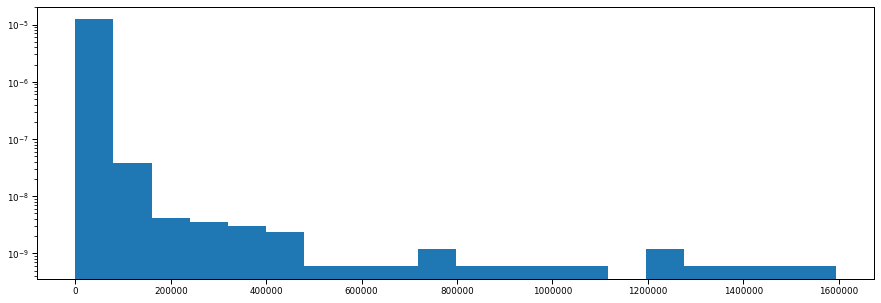

In [214]:
plt.hist(df['Confirmed'], density=True, bins=20) 
plt.yscale('log')

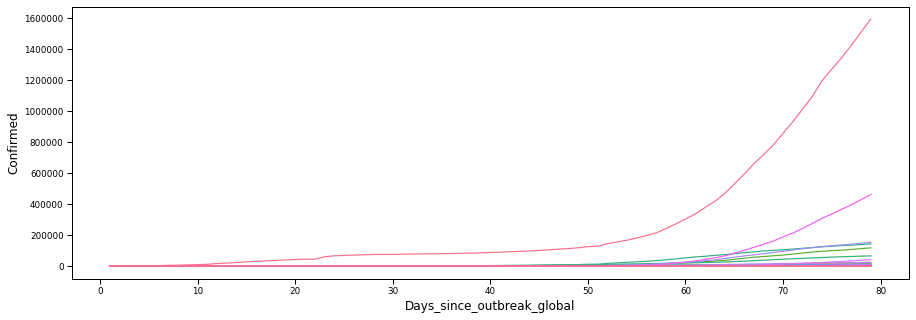

In [215]:
ax=sns.lineplot(data=df, hue="Country", x="Days_since_outbreak_global", y="Confirmed", ci=None)
ax.legend_.remove()

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   70  \
Country                                                             ...        
Afghanistan                  0   0   0   0   0   0   0   0   0   0  ...  174   
Albania                      0   0   0   0   0   0   0   0   0   0  ...  243   
Algeria                      0   0   0   0   0   0   0   0   0   0  ...  716   
Andorra                      0   0   0   0   0   0   0   0   0   0  ...  376   
Angola                       0   0   0   0   0   0   0   0   0   0  ...    7   

Days_since_outbreak_global   71   72    73    74    75    76    77    78    79  
Country                                                                         
Afghanistan                 237  273   281   299   349   367   423   444   484  
Albania                     259  277   304   333   361   377   383   400   409  
Algeria                     847  986  1171  1251  1320  1423  1468  1572  1666  
Andorra                     390  4

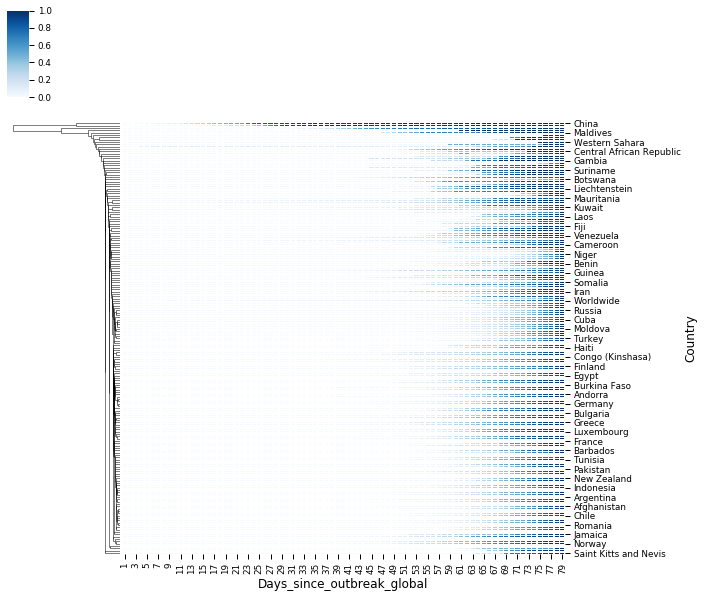

<Figure size 1800x576 with 0 Axes>

In [216]:
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":12,"axes.labelsize":12})   
def group_and_chart(Geography, Figure, Data):
    grouped = Data.groupby(['Days_since_outbreak_global',Geography])[Figure].sum()
    grouped= pd.DataFrame(grouped) 
    grouped.reset_index(inplace=True)
    grouped=grouped.pivot(index='Days_since_outbreak_global', columns=Geography, values=Figure)
    grouped = grouped.T[(grouped != 0).any()].T
    grouped = grouped.transpose()
    grouped.fillna(0, inplace=True)
    print(grouped.head())
    sns.clustermap(grouped, cmap="Blues", linewidth=.5, standard_scale=0,  col_cluster=False, method='single')
    plt.figure(figsize=(25,8))
    
group_and_chart(Geography='Country', Figure='Confirmed', Data=df)

In [217]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv'
df_country = pd.read_csv(url)
df_country = df_country.drop_duplicates(subset=['Country_Region'], keep=False)
df_country

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population
0,4,AF,AFG,4.00,nan,NaN,NaN,Afghanistan,33.94,67.71,Afghanistan,38928341.00
1,8,AL,ALB,8.00,nan,NaN,NaN,Albania,41.15,20.17,Albania,2877800.00
2,12,DZ,DZA,12.00,nan,NaN,NaN,Algeria,28.03,1.66,Algeria,43851043.00
3,20,AD,AND,20.00,nan,NaN,NaN,Andorra,42.51,1.52,Andorra,77265.00
4,24,AO,AGO,24.00,nan,NaN,NaN,Angola,-11.20,17.87,Angola,32866268.00
...,...,...,...,...,...,...,...,...,...,...,...,...
175,704,VN,VNM,704.00,nan,NaN,NaN,Vietnam,14.06,108.28,Vietnam,97338583.00
176,275,PS,PSE,275.00,nan,NaN,NaN,West Bank and Gaza,31.95,35.23,West Bank and Gaza,5101416.00
177,732,EH,ESH,732.00,nan,NaN,NaN,Western Sahara,24.22,-12.89,Western Sahara,597330.00
178,894,ZM,ZMB,894.00,nan,NaN,NaN,Zambia,-13.13,27.85,Zambia,18383956.00


In [218]:
# apply the mapping to df
df = pd.merge(df, df_country[['Country_Region','iso2']], left_on='Country', right_on='Country_Region', how='left')
df

,Confirmed,Country,Date,Lat,Long,Province,Province_and_country,Days_since_outbreak_global,Country_Region,iso2
0,0,Afghanistan,2020-01-22,33.00,65.00,NaN,Afghanistan,1,Afghanistan,AF
1,0,Albania,2020-01-22,41.15,20.17,NaN,Albania,1,Albania,AL
2,0,Algeria,2020-01-22,28.03,1.66,NaN,Algeria,1,Algeria,DZ
3,0,Andorra,2020-01-22,42.51,1.52,NaN,Andorra,1,Andorra,AD
4,0,Angola,2020-01-22,-11.20,17.87,NaN,Angola,1,Angola,AO
...,...,...,...,...,...,...,...,...,...,...
20851,1272115,Worldwide,2020-04-05,nan,nan,NaN,Worldwide,75,NaN,NaN
20852,1345101,Worldwide,2020-04-06,nan,nan,NaN,Worldwide,76,NaN,NaN
20853,1426096,Worldwide,2020-04-07,nan,nan,NaN,Worldwide,77,NaN,NaN
20854,1511104,Worldwide,2020-04-08,nan,nan,NaN,Worldwide,78,NaN,NaN


In [219]:
def alpha2_to_continent(iso):
    try: cont = pc.country_alpha2_to_continent_code(iso)
    except: cont = float('NaN')
    return cont

df['Continent'] = df['iso2'].apply(alpha2_to_continent) # get continent code

df.loc[df['Country'] == "Diamond Princess", 'Continent'] = "Diamond Princess"
df.loc[df['Country'] == "MS Zaandam", 'Continent'] = "MS Zaandam"
df.loc[df['Country'] == "Netherlands", 'Continent'] = "EU"
df.loc[df['Country'] == "Holy See", 'Continent'] = "AS"
df.loc[df['Country'] == "Namibia", 'Continent'] = "AF"
df.loc[df['Country'] == "Timor-Leste", 'Continent'] = "AS"
df.loc[df['Country'] == "Western Sahara", 'Continent'] = "AF"
df.loc[df['Country'] == "Worldwide", 'Continent'] = "WL"


df['Continent'] = df['Continent'].map({'WL':'Worldwide','MS Zaandam':'Ships','Diamond Princess':'Ships','AF':'Africa','AS':'Asia','EU':'Europe','NA':'North America','OC':'Oceania','SA':'South America'})

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...  \
Continent                                                           ...   
Africa                       0   0   0   0   0   0   0   0   0   0  ...   
Asia                         6  10  17  23  30  35  49  56  67  87  ...   
Europe                       0   0   0   0   0   1   4   5   5  11  ...   
North America                0   0   0   0   0   0   0   0   0   0  ...   
Oceania                      0   0   0   0   0   0   0   0   0   0  ...   

Days_since_outbreak_global      70      71      72      73      74      75  \
Continent                                                                    
Africa                        5781    6380    7032    7913    8592    9302   
Asia                         96180  104643  113860  122427  131340  140605   
Europe                      370517  397564  426434  453425  478573  500279   
North America                 4372    4773    5301    5787    6289    6951   
Oceani

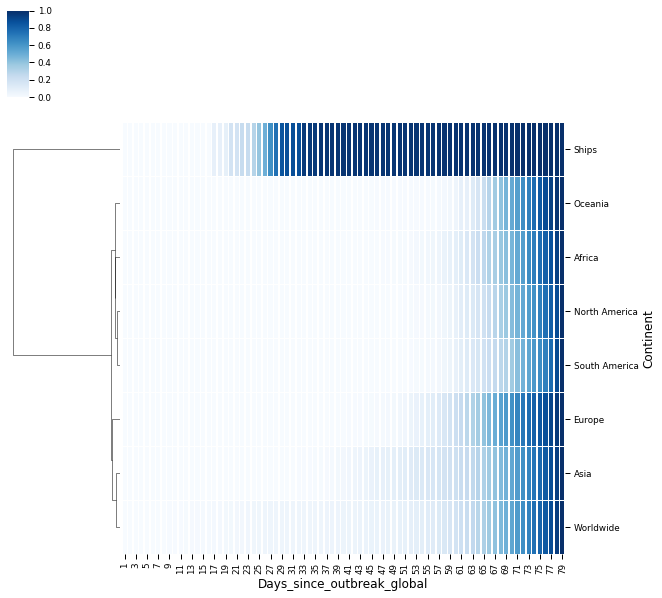

<Figure size 1800x576 with 0 Axes>

In [220]:
group_and_chart(Geography='Continent', Figure='Confirmed', Data=df)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   70  \
Country                                                             ...        
Afghanistan                  0   0   0   0   0   0   0   0   0   0  ...  174   
Armenia                      0   0   0   0   0   0   0   0   0   0  ...  532   
Azerbaijan                   0   0   0   0   0   0   0   0   0   0  ...  298   
Bahrain                      0   0   0   0   0   0   0   0   0   0  ...  567   
Bangladesh                   0   0   0   0   0   0   0   0   0   0  ...   51   

Days_since_outbreak_global   71   72   73   74   75   76   77   78   79  
Country                                                                  
Afghanistan                 237  273  281  299  349  367  423  444  484  
Armenia                     571  663  736  770  822  833  853  881  921  
Azerbaijan                  359  400  443  521  584  641  717  822  926  
Bahrain                     569  643  672  688  700  756  811  823  8

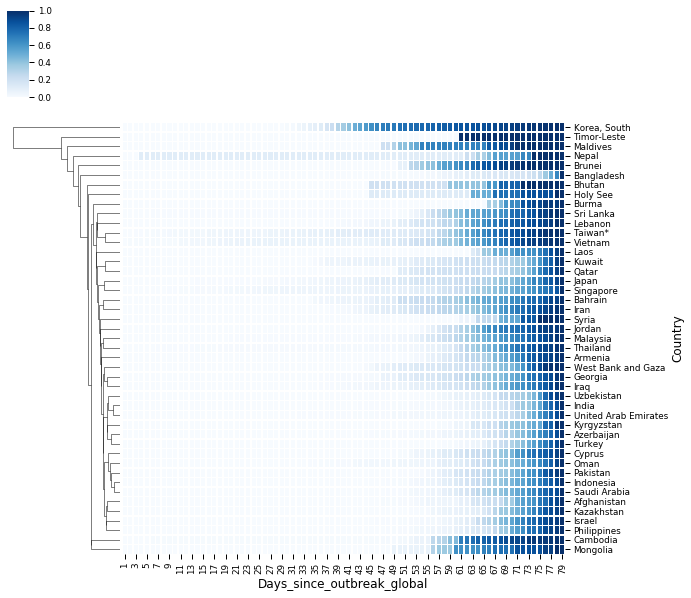

<Figure size 1800x576 with 0 Axes>

In [221]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...  \
Country                                                             ...   
Albania                      0   0   0   0   0   0   0   0   0   0  ...   
Andorra                      0   0   0   0   0   0   0   0   0   0  ...   
Austria                      0   0   0   0   0   0   0   0   0   0  ...   
Belarus                      0   0   0   0   0   0   0   0   0   0  ...   
Belgium                      0   0   0   0   0   0   0   0   0   0  ...   

Days_since_outbreak_global     70     71     72     73     74     75     76  \
Country                                                                       
Albania                       243    259    277    304    333    361    377   
Andorra                       376    390    428    439    466    501    525   
Austria                     10180  10711  11129  11524  11781  12051  12297   
Belarus                       152    163    304    351    440    562    700   


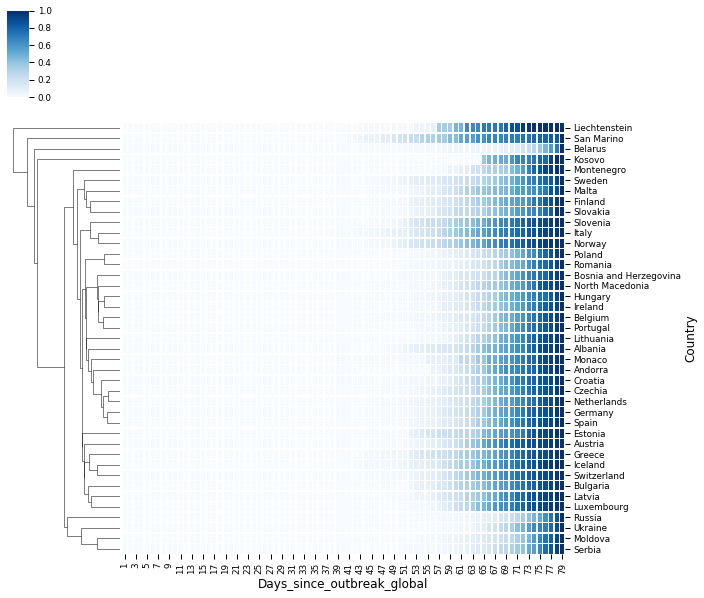

<Figure size 1800x576 with 0 Axes>

In [222]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   70  \
Country                                                             ...        
Algeria                      0   0   0   0   0   0   0   0   0   0  ...  716   
Angola                       0   0   0   0   0   0   0   0   0   0  ...    7   
Benin                        0   0   0   0   0   0   0   0   0   0  ...    9   
Botswana                     0   0   0   0   0   0   0   0   0   0  ...    4   
Burkina Faso                 0   0   0   0   0   0   0   0   0   0  ...  261   

Days_since_outbreak_global   71   72    73    74    75    76    77    78    79  
Country                                                                         
Algeria                     847  986  1171  1251  1320  1423  1468  1572  1666  
Angola                        8    8     8    10    14    16    17    19    19  
Benin                        13   13    16    16    22    26    26    26    26  
Botswana                      4   

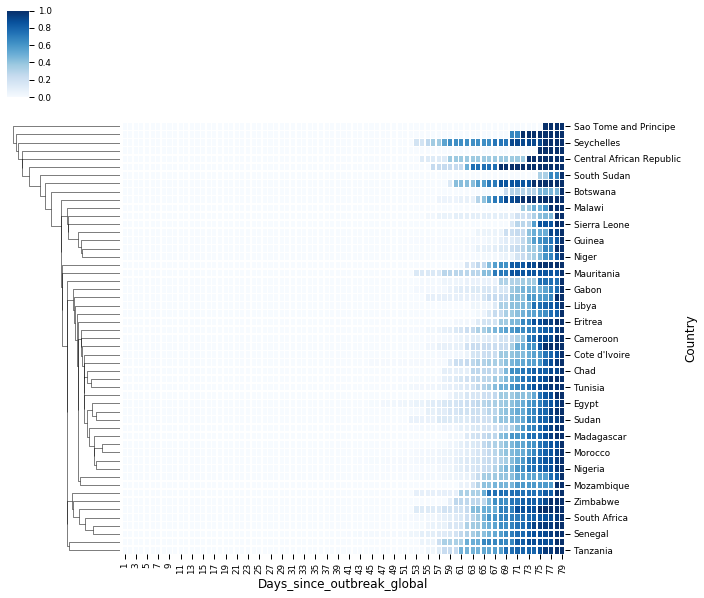

<Figure size 1800x576 with 0 Axes>

In [223]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   70  \
Country                                                             ...        
Antigua and Barbuda          0   0   0   0   0   0   0   0   0   0  ...    7   
Bahamas                      0   0   0   0   0   0   0   0   0   0  ...   14   
Barbados                     0   0   0   0   0   0   0   0   0   0  ...   34   
Belize                       0   0   0   0   0   0   0   0   0   0  ...    3   
Costa Rica                   0   0   0   0   0   0   0   0   0   0  ...  347   

Days_since_outbreak_global   71   72   73   74   75   76   77   78   79  
Country                                                                  
Antigua and Barbuda           7    9   15   15   15   15   19   19   19  
Bahamas                      21   24   24   28   28   29   33   40   41  
Barbados                     34   46   51   52   56   60   63   63   66  
Belize                        3    3    4    4    5    7    7    8   

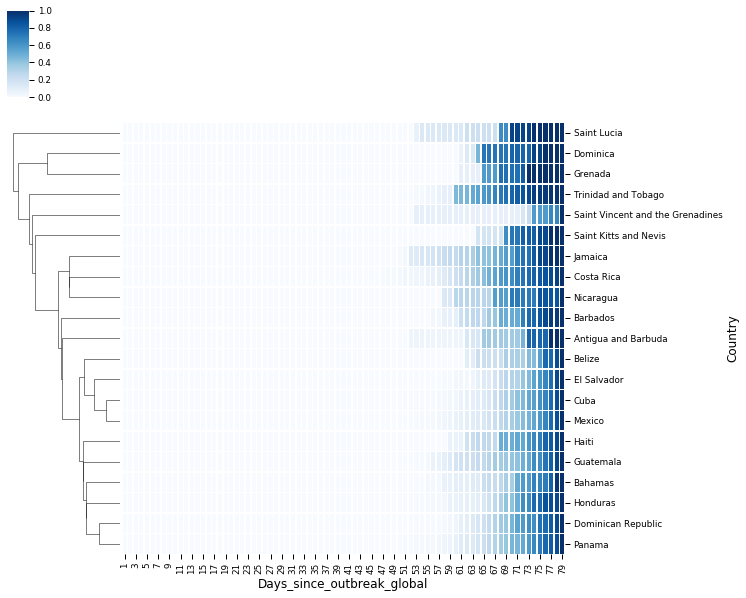

<Figure size 1800x576 with 0 Axes>

In [224]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   70  \
Country                                                             ...        
Fiji                         0   0   0   0   0   0   0   0   0   0  ...    5   
New Zealand                  0   0   0   0   0   0   0   0   0   0  ...  647   
Papua New Guinea             0   0   0   0   0   0   0   0   0   0  ...    1   

Days_since_outbreak_global   71   72   73   74    75    76    77    78    79  
Country                                                                       
Fiji                          5    7    7   12    12    14    15    15    15  
New Zealand                 708  797  868  950  1039  1106  1160  1210  1239  
Papua New Guinea              1    1    1    1     1     2     2     2     2  

[3 rows x 79 columns]


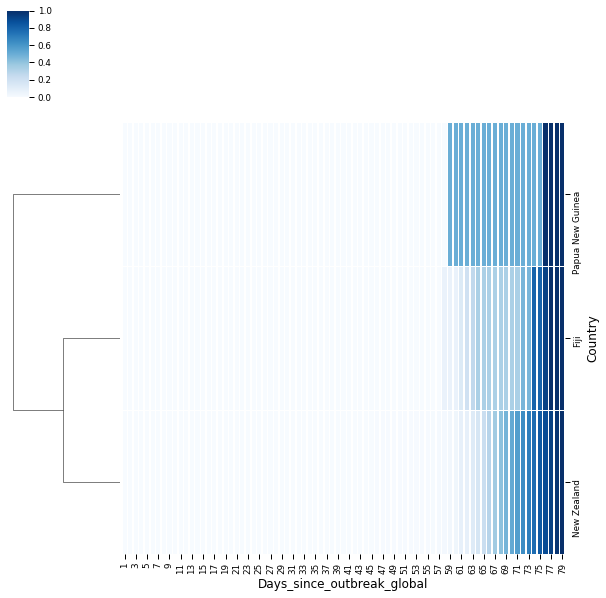

<Figure size 1800x576 with 0 Axes>

In [225]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...    70  \
Country                                                             ...         
Argentina                    0   0   0   0   0   0   0   0   0   0  ...  1054   
Bolivia                      0   0   0   0   0   0   0   0   0   0  ...   107   
Brazil                       0   0   0   0   0   0   0   0   0   0  ...  5717   
Chile                        0   0   0   0   0   0   0   0   0   0  ...  2738   
Colombia                     0   0   0   0   0   0   0   0   0   0  ...   906   

Days_since_outbreak_global    71    72    73     74     75     76     77  \
Country                                                                    
Argentina                   1054  1133  1265   1451   1451   1554   1628   
Bolivia                      115   123   132    139    157    183    194   
Brazil                      6836  8044  9056  10360  11130  12161  14034   
Chile                       3031  3404  3737   4161 

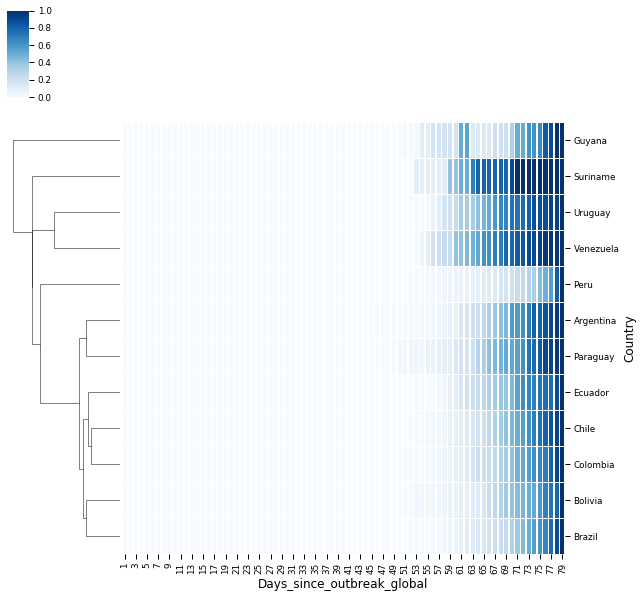

<Figure size 1800x576 with 0 Axes>

In [226]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

## Analysis - daily increase

In [227]:
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Week_number'] = df['Date'].dt.week
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Confirmed_lag_1'] = df.groupby('Province_and_country')['Confirmed'].shift(1)
df['Daily_increase_confirmed'] = df['Confirmed']-df['Confirmed_lag_1']
df = df.replace([np.inf, -np.inf], np.nan)
#df.loc[df['Daily_increase_confirmed'] == np.inf, 'Daily_increase_confirmed'] = df['Confirmed']
#df.loc[df['Daily_increase_death'] == np.inf, 'Daily_increase_death'] = df['Deaths']
df = df.replace(np.nan, 0)
df

,Confirmed,Country,Date,Lat,Long,Province,Province_and_country,Days_since_outbreak_global,Country_Region,iso2,Continent,Day,Weekday,Week_number,Quarter,Month,Year,Confirmed_lag_1,Daily_increase_confirmed
0,0,Afghanistan,2020-01-22,33.00,65.00,0,Afghanistan,1,Afghanistan,AF,Asia,22,2,4,1,1,2020,0.00,0.00
1,0,Albania,2020-01-22,41.15,20.17,0,Albania,1,Albania,AL,Europe,22,2,4,1,1,2020,0.00,0.00
2,0,Algeria,2020-01-22,28.03,1.66,0,Algeria,1,Algeria,DZ,Africa,22,2,4,1,1,2020,0.00,0.00
3,0,Andorra,2020-01-22,42.51,1.52,0,Andorra,1,Andorra,AD,Europe,22,2,4,1,1,2020,0.00,0.00
4,0,Angola,2020-01-22,-11.20,17.87,0,Angola,1,Angola,AO,Africa,22,2,4,1,1,2020,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20851,1272115,Worldwide,2020-04-05,0.00,0.00,0,Worldwide,75,0,0,Worldwide,5,6,14,2,4,2020,1197408.00,74707.00
20852,1345101,Worldwide,2020-04-06,0.00,0.00,0,Worldwide,76,0,0,Worldwide,6,0,15,2,4,2020,1272115.00,72986.00
20853,1426096,Worldwide,2020-04-07,0.00,0.00,0,Worldwide,77,0,0,Worldwide,7,1,15,2,4,2020,1345101.00,80995.00
20854,1511104,Worldwide,2020-04-08,0.00,0.00,0,Worldwide,78,0,0,Worldwide,8,2,15,2,4,2020,1426096.00,85008.00


In [228]:
df.to_csv('df_m.CSV',sep=',')

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Albania                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Algeria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Andorra                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Angola                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...     70     71     72     73    74    75  \
Country                     ...                                           
Afghanistan                 ...   4.00  63.00  36.00   8.00 18.00 50.00   
Albania                     ...  20.00  16.00  18.00  27.00 29.00 28.00   
Algeria                     ... 132.00 131.00 139.00 185.00 80.00 69.00   
Andorra                     ...   6.00  14.00  38.00  11.00 27.0

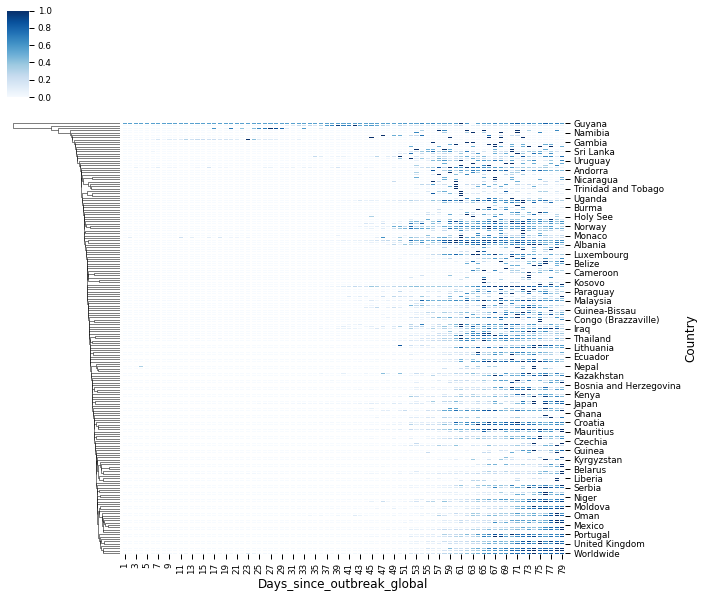

<Figure size 1800x576 with 0 Axes>

In [229]:
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global   1     2      3      4      5      6       7   \
Continent                                                                   
0                          0.00 95.00 280.00 487.00 677.00 803.00 2634.00   
Africa                     0.00  0.00   0.00   0.00   0.00   0.00    0.00   
Asia                       0.00  4.00   7.00   6.00   7.00   5.00   14.00   
Europe                     0.00  0.00   0.00   0.00   0.00   1.00    3.00   
North America              0.00  0.00   0.00   0.00   0.00   0.00    0.00   

Days_since_outbreak_global     8       9       10  ...       70       71  \
Continent                                          ...                     
0                          580.00 2057.00 1667.00  ... 38718.00 36175.00   
Africa                       0.00    0.00    0.00  ...   585.00   599.00   
Asia                         7.00   11.00   20.00  ...  8708.00  8463.00   
Europe                       1.00    0.00    6.00  ... 24270.00 27047.00   
Nort

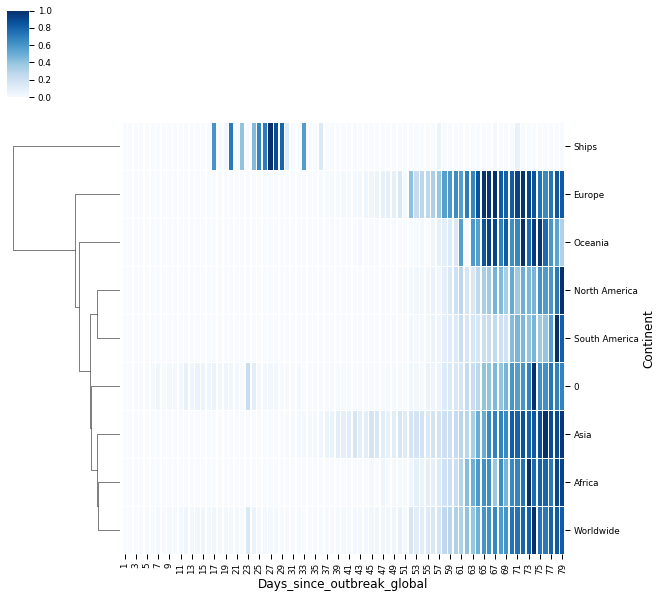

<Figure size 1800x576 with 0 Axes>

In [230]:
group_and_chart(Geography='Continent', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Armenia                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Azerbaijan                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bahrain                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bangladesh                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...    70    71    72    73    74    75    76  \
Country                     ...                                             
Afghanistan                 ...  4.00 63.00 36.00  8.00 18.00 50.00 18.00   
Armenia                     ... 50.00 39.00 92.00 73.00 34.00 52.00 11.00   
Azerbaijan                  ... 25.00 61.00 41.00 43.00 78.00 63.00 57.00   
Bahrain                     ... 52.00  2.00 74.00 29.0

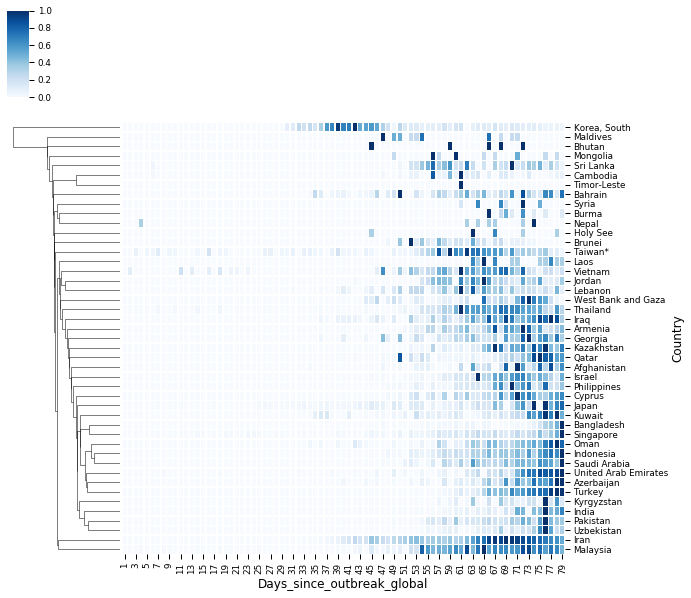

<Figure size 1800x576 with 0 Axes>

In [231]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Albania                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Andorra                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Austria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belarus                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belgium                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...     70      71      72      73      74  \
Country                     ...                                          
Albania                     ...  20.00   16.00   18.00   27.00   29.00   
Andorra                     ...   6.00   14.00   38.00   11.00   27.00   
Austria                     ... 562.00  531.00  418.00  395.00  257.00   
Belarus                     ...   0.00   11.00  141.00   47.00   89.0

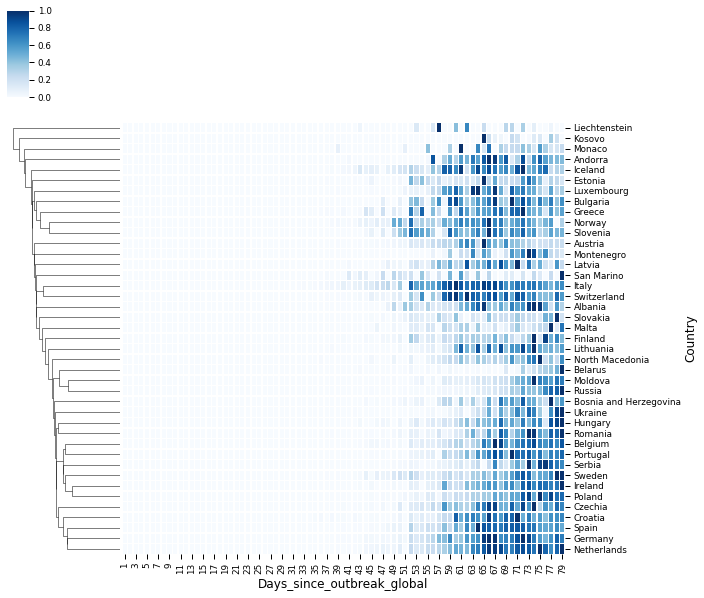

<Figure size 1800x576 with 0 Axes>

In [232]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Algeria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Angola                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Benin                      0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Botswana                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Burkina Faso               0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...     70     71     72     73    74    75  \
Country                     ...                                           
Algeria                     ... 132.00 131.00 139.00 185.00 80.00 69.00   
Angola                      ...   0.00   1.00   0.00   0.00  2.00  4.00   
Benin                       ...   3.00   4.00   0.00   3.00  0.00  6.00   
Botswana                    ...   1.00   0.00   0.00   0.00  0.0

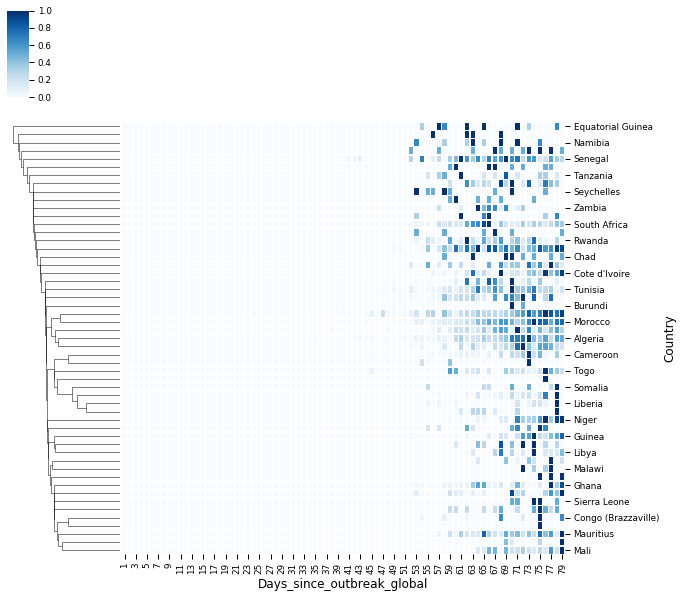

<Figure size 1800x576 with 0 Axes>

In [233]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Antigua and Barbuda        0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bahamas                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Barbados                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belize                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Costa Rica                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...    70    71    72    73    74    75    76  \
Country                     ...                                             
Antigua and Barbuda         ...  0.00  0.00  2.00  6.00  0.00  0.00  0.00   
Bahamas                     ...  0.00  7.00  3.00  0.00  4.00  0.00  1.00   
Barbados                    ...  1.00  0.00 12.00  5.00  1.00  4.00  4.00   
Belize                      ...  0.00  0.00  0.00  1.0

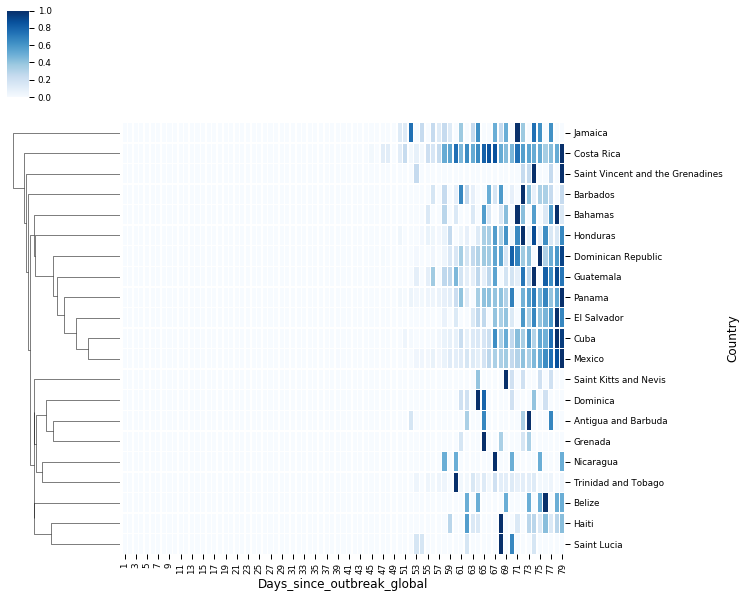

<Figure size 1800x576 with 0 Axes>

In [234]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Fiji                       0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
New Zealand                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Papua New Guinea           0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...    70    71    72    73    74    75    76  \
Country                     ...                                             
Fiji                        ...  0.00  0.00  2.00  0.00  5.00  0.00  2.00   
New Zealand                 ... 58.00 61.00 89.00 71.00 82.00 89.00 67.00   
Papua New Guinea            ...  0.00  0.00  0.00  0.00  0.00  0.00  1.00   

Days_since_outbreak_global    77    78    79  
Country                                       
Fiji                        1.00  0.00  0.00  
New Zealand                54.00 50.00 29.00  
Papua New Guinea         

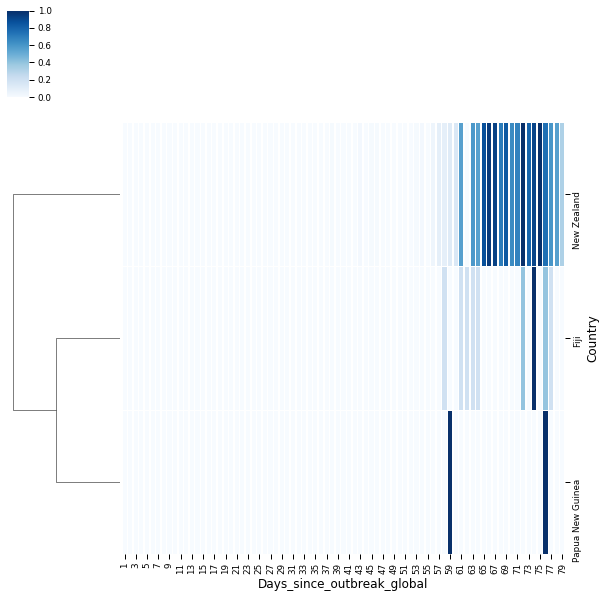

<Figure size 1800x576 with 0 Axes>

In [235]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Argentina                  0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bolivia                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Brazil                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Chile                      0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Colombia                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...      70      71      72      73      74  \
Country                     ...                                           
Argentina                   ...  234.00    0.00   79.00  132.00  186.00   
Bolivia                     ...   10.00    8.00    8.00    9.00    7.00   
Brazil                      ... 1138.00 1119.00 1208.00 1012.00 1304.00   
Chile                       ...  289.00  293.00  373.00  333.00 

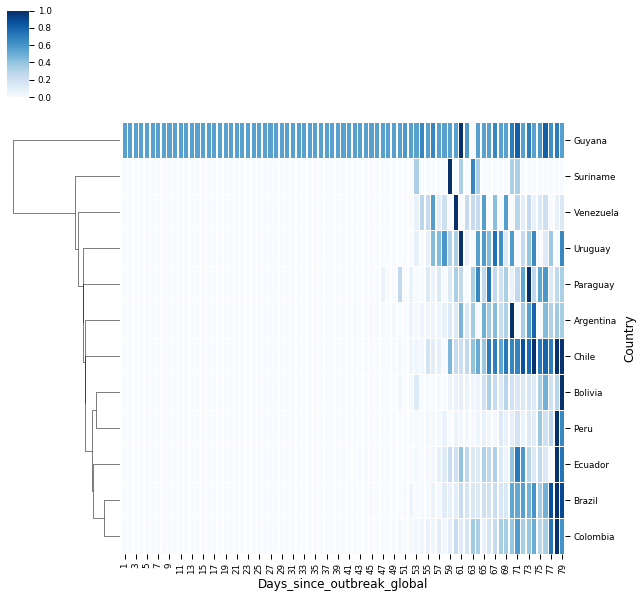

<Figure size 1800x576 with 0 Axes>

In [236]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

## Prediction

In [237]:
df_ml_confirmed_test = df.copy()
df_ml_confirmed_test['Confirmed_lag_1'] = df_ml_confirmed_test.groupby('Province_and_country')['Confirmed'].shift(1)
df_ml_confirmed_test['Confirmed'] = df_ml_confirmed_test['Confirmed']-df_ml_confirmed_test['Confirmed_lag_1']
df_ml_confirmed_test['Confirmed_lag_7'] = df_ml_confirmed_test.groupby('Province_and_country')['Confirmed'].shift(7)
df_ml_confirmed_test['Days_since_outbreak_country'] = df_ml_confirmed_test.loc[(df_ml_confirmed_test.Confirmed.notnull())].groupby(['Province_and_country','Lat','Long']).cumcount()+1
df_ml_confirmed_test = df_ml_confirmed_test.replace(np.nan, 0)
df_ml_confirmed_test = df_ml_confirmed_test[['Confirmed', 'Province_and_country', 'Days_since_outbreak_global', 'Date','Day','Weekday','Week_number','Quarter','Month','Year','Confirmed_lag_7','Days_since_outbreak_country']]
df_ml_confirmed_test

,Confirmed,Province_and_country,Days_since_outbreak_global,Date,Day,Weekday,Week_number,Quarter,Month,Year,Confirmed_lag_7,Days_since_outbreak_country
0,0.00,Afghanistan,1,2020-01-22,22,2,4,1,1,2020,0.00,0.00
1,0.00,Albania,1,2020-01-22,22,2,4,1,1,2020,0.00,0.00
2,0.00,Algeria,1,2020-01-22,22,2,4,1,1,2020,0.00,0.00
3,0.00,Andorra,1,2020-01-22,22,2,4,1,1,2020,0.00,0.00
4,0.00,Angola,1,2020-01-22,22,2,4,1,1,2020,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
20851,74707.00,Worldwide,75,2020-04-05,5,6,14,2,4,2020,59447.00,74.00
20852,72986.00,Worldwide,76,2020-04-06,6,0,15,2,4,2020,62249.00,75.00
20853,80995.00,Worldwide,77,2020-04-07,7,1,15,2,4,2020,75098.00,76.00
20854,85008.00,Worldwide,78,2020-04-08,8,2,15,2,4,2020,75118.00,77.00


In [238]:
#Confirmed
df_ml_confirmed = df.copy()
df_ml_confirmed['Confirmed_lag_7'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed'].shift(7)
df_ml_confirmed['Days_since_outbreak_country'] = df_ml_confirmed.loc[(df_ml_confirmed.Confirmed.notnull())].groupby(['Province_and_country','Lat','Long']).cumcount()+1
df_ml_confirmed = df_ml_confirmed.replace(np.nan, 0)
df_ml_confirmed = df_ml_confirmed[['Confirmed', 'Province_and_country', 'Days_since_outbreak_global', 'Date','Day','Weekday','Week_number','Quarter','Month','Year', 'Confirmed_lag_7','Days_since_outbreak_country']]
df_ml_confirmed

,Confirmed,Province_and_country,Days_since_outbreak_global,Date,Day,Weekday,Week_number,Quarter,Month,Year,Confirmed_lag_7,Days_since_outbreak_country
0,0,Afghanistan,1,2020-01-22,22,2,4,1,1,2020,0.00,1
1,0,Albania,1,2020-01-22,22,2,4,1,1,2020,0.00,1
2,0,Algeria,1,2020-01-22,22,2,4,1,1,2020,0.00,1
3,0,Andorra,1,2020-01-22,22,2,4,1,1,2020,0.00,1
4,0,Angola,1,2020-01-22,22,2,4,1,1,2020,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...
20851,1272115,Worldwide,75,2020-04-05,5,6,14,2,4,2020,720140.00,75
20852,1345101,Worldwide,76,2020-04-06,6,0,15,2,4,2020,782389.00,76
20853,1426096,Worldwide,77,2020-04-07,7,1,15,2,4,2020,857487.00,77
20854,1511104,Worldwide,78,2020-04-08,8,2,15,2,4,2020,932605.00,78


In [195]:
df_ml_confirmed.to_csv('df_ml.CSV',sep=',')

### One Country Test

In [239]:
split_date = datetime.today() - timedelta(days=8)
split_date

datetime.datetime(2020, 4, 2, 15, 46, 4, 96510)

In [240]:
def create_x_y(df, label=None):
    df.index = df['Date']
    X = df[['Days_since_outbreak_global','Day','Weekday','Week_number','Quarter','Month','Year', 'Confirmed_lag_7','Days_since_outbreak_country']]
    if label:
        y = df[label]
        return X, y
    return X

18222.743301238563
21089.1253834651
0.2220874343955266


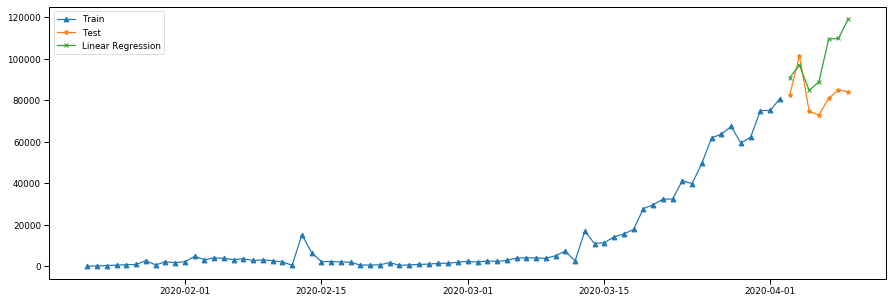

In [287]:
List = df_ml_confirmed_test.loc[(df_ml_confirmed_test.Province_and_country == "Worldwide")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

linear_regressor.fit(X_train, y_train)

Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='Linear Regression', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(np.sqrt(mean_squared_log_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))

14583.110385641845
15862.953801668482
0.17924376811255138


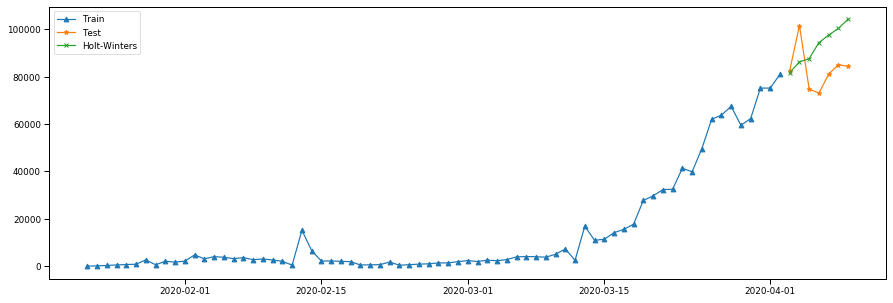

In [286]:
List = df_ml_confirmed_test.loc[(df_ml_confirmed_test.Province_and_country == "Worldwide")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model

hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

pred = hw_model.predict(start=test.index[0], end=test.index[-1])
pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=test)))
print(np.sqrt(mean_squared_log_error(y_pred=pred, y_true=test)))

In [86]:
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

cfg_list = exp_smoothing_configs(seasonal=[6]) #[0,6,12]

In [87]:
edf = List['Confirmed']
ts = edf[:split_date].copy()
ts_v = edf[split_date:].copy()
ind = edf.index[-7:]  

print("Holt's Winter Model")
best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    print(j)
    try:
        cg = cfg_list[j]
        print(cg)
        t,d,s,p,b,r = cg
        train = edf[:split_date].copy()
        test = edf[split_date:split_date+timedelta(days=7)].copy()
        # define model
        if (t == None):
            model = ExponentialSmoothing(ts, trend=t, seasonal=s, seasonal_periods=p)
        else:
            model = ExponentialSmoothing(ts, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        # fit model
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        # make one step forecast
        y_forecast = model_fit.forecast(7)
        rmse = np.sqrt(mean_squared_error(ts_v,y_forecast))
        print(rmse)
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        continue

Holt's Winter Model
0
['add', True, 'add', 6, True, True]
1
['add', True, 'add', 6, True, False]
2
['add', True, 'add', 6, False, True]
1218.8565781948485
3
['add', True, 'add', 6, False, False]
1239.7756832103773
4
['add', True, 'mul', 6, True, True]
5
['add', True, 'mul', 6, True, False]
6
['add', True, 'mul', 6, False, True]
7
['add', True, 'mul', 6, False, False]
8
['add', True, None, 6, True, True]
9
['add', True, None, 6, True, False]
10
['add', True, None, 6, False, True]
11
['add', True, None, 6, False, False]
12
['add', False, 'add', 6, True, True]
13
['add', False, 'add', 6, True, False]
14
['add', False, 'add', 6, False, True]
1280.730909249979
15
['add', False, 'add', 6, False, False]
1280.7312173267167
16
['add', False, 'mul', 6, True, True]
17
['add', False, 'mul', 6, True, False]
18
['add', False, 'mul', 6, False, True]
19
['add', False, 'mul', 6, False, False]
20
['add', False, None, 6, True, True]
21
['add', False, None, 6, True, False]
22
['add', False, None, 6, False

In [88]:
def model_eval(y, predictions):

    # Import library for metrics
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Mean absolute error (MAE)
    mae = mean_absolute_error(y, predictions)

    # Mean squared error (MSE)
    mse = mean_squared_error(y, predictions)


    # SMAPE is an alternative for MAPE when there are zeros in the testing data. It
    # scales the absolute percentage by the sum of forecast and observed values
    SMAPE = np.mean(np.abs((y - predictions) / ((y + predictions)/2))) * 100


    # Calculate the Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y, predictions))

    # Calculate the Mean Absolute Percentage Error
    # y, predictions = check_array(y, predictions)
    MAPE = np.mean(np.abs((y - predictions) / y)) * 100

    # mean_forecast_error
    mfe = np.mean(y - predictions)

    # NMSE normalizes the obtained MSE after dividing it by the test variance. It
    # is a balanced error measure and is very effective in judging forecast
    # accuracy of a model.

    # normalised_mean_squared_error
    NMSE = mse / (np.sum((y - np.mean(y)) ** 2)/(len(y)-1))


    # theil_u_statistic
    # It is a normalized measure of total forecast error.
    error = y - predictions
    mfe = np.sqrt(np.mean(predictions**2))
    mse = np.sqrt(np.mean(y**2))
    rmse = np.sqrt(np.mean(error**2))
    theil_u_statistic =  rmse / (mfe*mse)


    # mean_absolute_scaled_error
    # This evaluation metric is used to over come some of the problems of MAPE and
    # is used to measure if the forecasting model is better than the naive model or
    # not.


    # Print metrics
    print('Mean Absolute Error:', round(mae, 3))
    print('Mean Squared Error:', round(mse, 3))
    print('Root Mean Squared Error:', round(rmse, 3))
    print('Mean absolute percentage error:', round(MAPE, 3))
    print('Scaled Mean absolute percentage error:', round(SMAPE, 3))
    print('Mean forecast error:', round(mfe, 3))
    print('Normalised mean squared error:', round(NMSE, 3))
    print('Theil_u_statistic:', round(theil_u_statistic, 3))

In [89]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('01-Apr-2019'), end = pd.to_datetime('29-Feb-2020'))
pred_HW = fit2.forecast(7)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([List, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW))
print('-*-'*20)

# 15.570830579664698 ['add', True, 'add', 12, False, False]
# Mean Absolute Error: 10.456
# Mean Squared Error: 481.948
# Root Mean Squared Error: 15.571
# Mean absolute percentage error: 2.317
# Scaled Mean absolute percentage error: 2.273
# Mean forecast error: 483.689
# Normalised mean squared error: 0.04
# Theil_u_statistic: 0.0
# None
# -*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

1212.3789799791577 [None, True, 'add', 6, False, True]
Mean Absolute Error: 987.54
Mean Squared Error: 5353.074
Root Mean Squared Error: 1212.379
Mean absolute percentage error: 20.118
Scaled Mean absolute percentage error: 19.478
Mean forecast error: 4972.921
Normalised mean squared error: 0.85
Theil_u_statistic: 0.0
None
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


6475.081504971512
9180.80653865347
0.10535241649872552


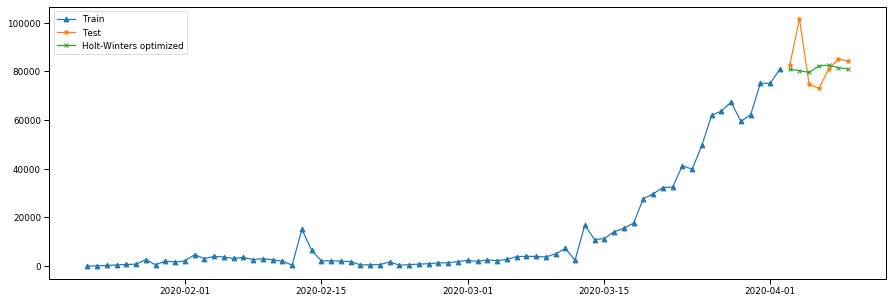

In [285]:
List = df_ml_confirmed_test.loc[(df_ml_confirmed_test.Province_and_country == "Worldwide")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

model = ExponentialSmoothing(train, trend=None, seasonal='add', seasonal_periods=6, damped=False) #Tuned_model

hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

pred = hw_model.predict(start=test.index[0], end=test.index[-1])
pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters optimized', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=test)))
print(np.sqrt(mean_squared_log_error(y_pred=pred, y_true=test)))

#[None, True, 'add', 6, False, True]
# t1,d1,s1,p1,b1,r1

17867.340448337127
19335.8571435167
0.2139662630744227


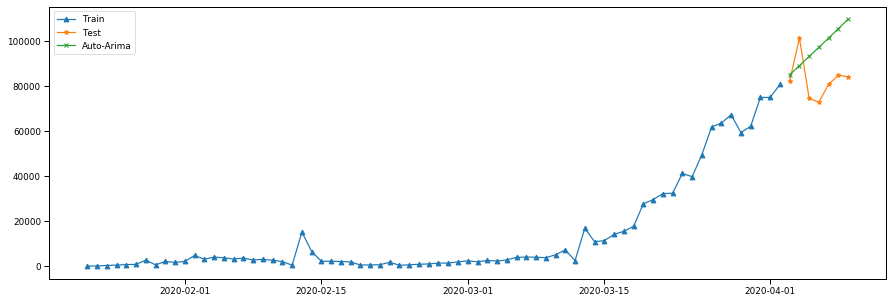

In [284]:
List = df_ml_confirmed_test.loc[(df_ml_confirmed_test.Province_and_country == "Worldwide")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

stepwise_fit = auto_arima(train, error_action='ignore', trace=False,
                      suppress_warnings=True, maxiter=1000,
                      seasonal=False, stepwise=True)  # set to stepwise

stepwise_fit.summary()

pred = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= test.index)

pred.columns = ['Confirmed']

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Auto-Arima', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=test)))
print(np.sqrt(mean_squared_log_error(y_pred=pred, y_true=test)))

5662.161830357143
8573.526278408805
0.09684729475427178


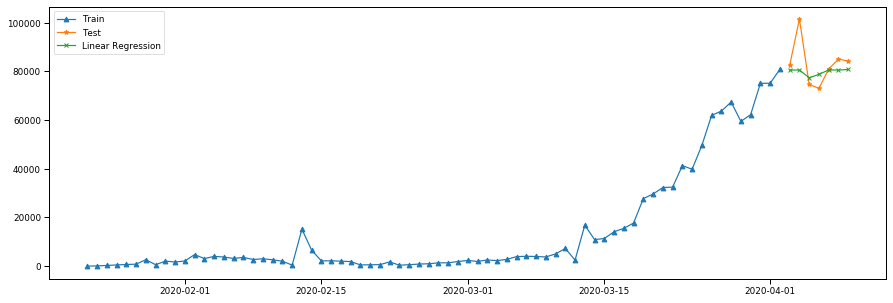

In [283]:
List = df_ml_confirmed_test.loc[(df_ml_confirmed_test.Province_and_country == "Worldwide")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

reg = xgb.XGBRegressor(n_estimators=1000, objective= 'reg:squarederror')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=200,
       verbose=False) # Change verbose to True if you want to see it train

Confirmed_test['Confirmed_Prediction'] = reg.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='Linear Regression', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(np.sqrt(mean_squared_log_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3760 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 8288 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 13333 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 13500 out of 13500 | elapsed:   10.3s finished


5662.161830357143
8573.526278408805
0.09684729475427178


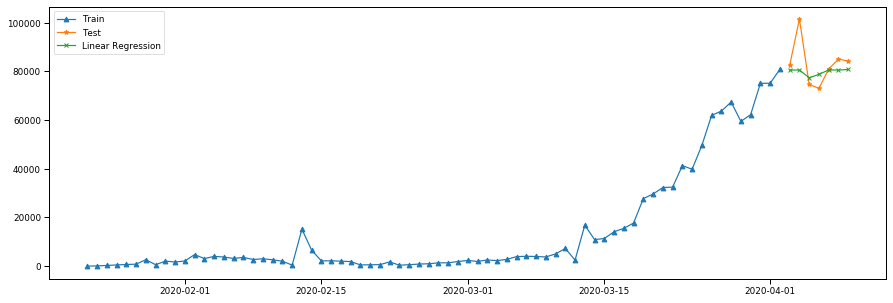

In [291]:
param_test = {
 'gamma':[i/10.0 for i in range(0,5)],
 'max_depth':[4,5,6],
 'min_child_weight':[6,8,10,12],
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)],
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=47, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=-1, scale_pos_weight=1,seed=27), 
 param_grid = param_test, n_jobs=-1, iid=False, cv=5, verbose=2)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

best_params_xgb = gsearch.best_estimator_.get_xgb_params()
xgtrain = xgb.DMatrix(data=X_train,label=y_train)
xgtest = xgb.DMatrix(X_test)
cvresult = xgb.cv(best_params_xgb, xgtrain, num_boost_round=gsearch.best_estimator_.get_xgb_params()['n_estimators'], nfold=5,
            metrics='rmse', early_stopping_rounds=200)
gsearch.best_estimator_.set_params(n_estimators=cvresult.shape[0])

#Fit the algorithm on the data
gsearch.best_estimator_.fit(X_train, y_train,eval_metric='rmse')

Confirmed_test['Confirmed_Prediction'] = reg.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='Linear Regression', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(np.sqrt(mean_squared_log_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14232.008581924509
15420.025750493234
0.17403916380679857


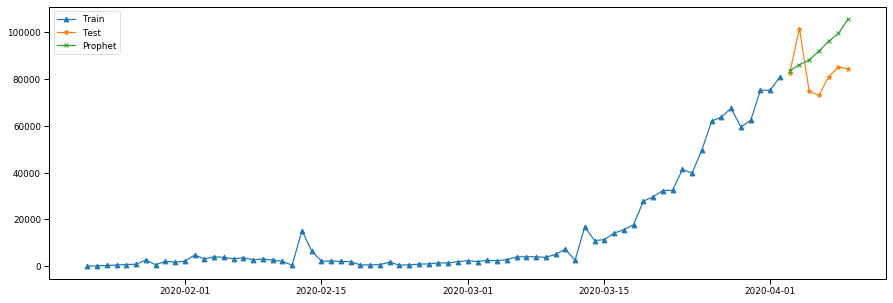

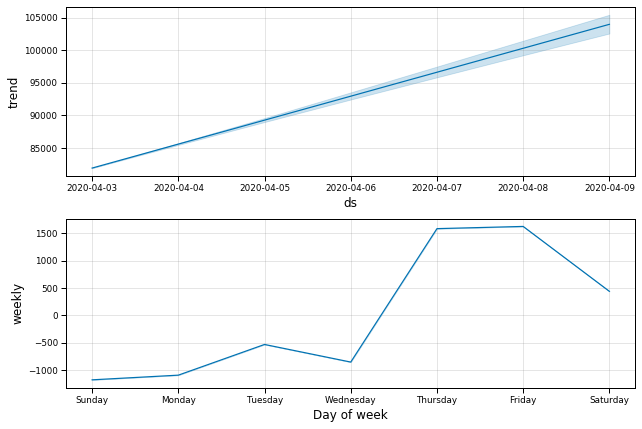

In [282]:
List = df_ml_confirmed_test.loc[(df_ml_confirmed_test.Province_and_country == "Worldwide")]

List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = train[['Confirmed','Date']]
test = test[['Confirmed','Date']]

model = Prophet()
model.fit(train.reset_index().rename(columns={'Date':'ds', 'Confirmed':'y'}))

pred = model.predict(df=test.reset_index().rename(columns={'Date':'ds'}))

test = test.reset_index(drop=True)
pred = pred.reset_index(drop=True)

plt.plot(train.Date, train.Confirmed, label='Train',marker ='^')
plt.plot(test.Date, test.Confirmed, label='Test', marker = "*")
plt.plot(test.Date, pred.yhat, label='Prophet', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred.yhat, y_true=test.Confirmed))
print(np.sqrt(mean_squared_error(y_pred=pred.yhat, y_true=test.Confirmed)))
print(np.sqrt(mean_squared_log_error(y_pred=pred.yhat, y_true=test.Confirmed)))

fig = model.plot_components(pred)

### All customers

In [49]:
df_ml_confirmed_var = pd.DataFrame(list(dict.fromkeys(df_ml_confirmed.Province_and_country)))
df_ml_confirmed_var.rename(columns={ df_ml_confirmed_var.columns[0]: "Value" }, inplace = True)
#df_ml_confirmed_var = df_ml_confirmed_var.loc[(df_ml_confirmed_var.Value == "Germany")]
#df_ml_confirmed_var = df_ml_confirmed_var.head(20)

#### Linear Regression

In [81]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed_test.loc[(df_ml_confirmed_test.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

    linear_regressor.fit(X_train, y_train)

    Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Linear Regression"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Linear = pd.concat(Train_and_Test_temp)
Train_and_Test = pd.concat(Train_and_Test_temp)


Finished!


In [82]:
Train_and_Test_Linear = Train_and_Test_Linear.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.SDMAE.notnull(), 'SDMAE']))

215.11177037522535
6.394440308004416
16.79504295618114


#### Holt-Winters (non-optimized)

In [52]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    model = ExponentialSmoothing(Confirmed_train_, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model
    hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

    Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=test.index[0], end=test.index[-1])
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Holt-Winters Non-optimized"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Holt = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Holt)


Finished!


In [53]:
Train_and_Test_Holt = Train_and_Test_Holt.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.SDMAE.notnull(), 'SDMAE']))

650.4038718421339
9.290121163921157
10.772879696462276


#### Holt-Winters (optimized)

In [54]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    model = ExponentialSmoothing(train, trend='add', seasonal='None', seasonal_periods=6, damped=True) #Tuned_model
    hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

    Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=test.index[0], end=test.index[-1])
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Holt-Winters Optimized"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Holt_optimized = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Holt_optimized)


Finished!


In [55]:
Train_and_Test_Holt_optimized = Train_and_Test_Holt_optimized.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.SDMAE.notnull(), 'SDMAE']))

87478.26871524875
291.29348584975276
33543.17108976384


#### Auto-ARIMA

In [56]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    stepwise_fit = auto_arima(Confirmed_train_, error_action='ignore', trace=False,
                      suppress_warnings=True, maxiter=100,
                      seasonal=True, stepwise=True)  # set to stepwise

    stepwise_fit.summary()

    Confirmed_test['Confirmed_Prediction'] = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= Confirmed_test_.index)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Auto-ARIMA"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_ARIMA = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_ARIMA)


Finished!


In [57]:
Train_and_Test_ARIMA = Train_and_Test_ARIMA.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.SDMAE.notnull(), 'SDMAE']))

488.0421480163235
8.82700338180045
1.6411183658724005


In [58]:
Train_and_Test['Update_date'] = datetime.today()

In [59]:
Train_and_Test.to_csv('Train_and_Test.CSV',sep=',')

In [60]:
Train_and_Test.to_excel('C:/Users/d6002091/Google Drive/Train_and_Test.xlsx', index = False)